# Lorenz system

The lorenz system is a nonlinear chaotic system which evolves along a strange attractor. THe equations are

\begin{align}
    \dot{x} &= \sigma( y - x) \\
    \dot{y} &= x (\rho - z) - y \\
    \dot{z} &= x\,y - \beta z
\end{align}

Following the PySINDy documentation, we use the parameters $\sigma = 10,\ \rho = 28,\ \beta = 8/3$ and start from the initial condition $(x, y, z) = (-8, 8, 27)$

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


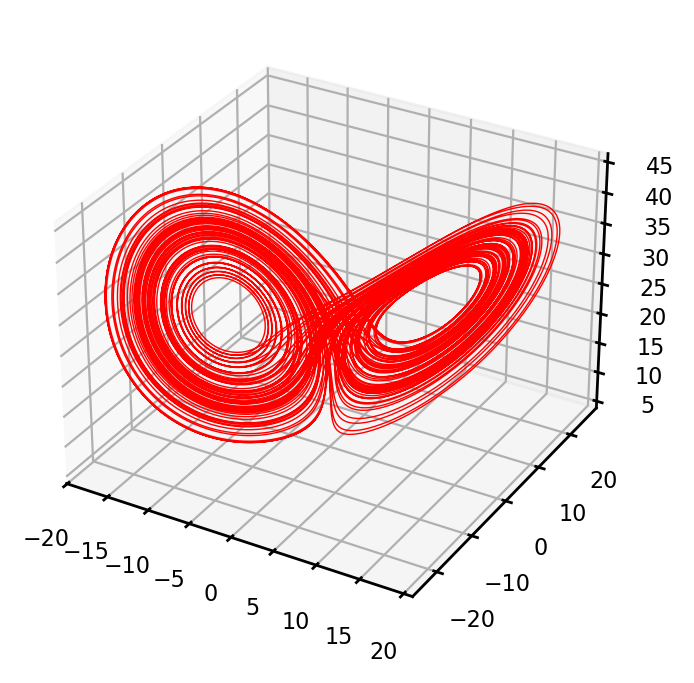

In [38]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

plt.style.use('../../figure_style.mplstyle')

def lorenz_system(t, xyz, sigma=10, rho=28, beta=8./3.):
    x, y, z = xyz
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return np.array([xdot, ydot, zdot])

# Generate data
dt = 1e-3
t0, t1 = 0, 100
tt = np.arange(t0, t1, dt)

xyz_init = np.array([-8, 8, 27])
xyz0 = solve_ivp(lorenz_system, [t0, t1], xyz_init, t_eval=tt).y.T

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(4, 4))
ax.plot(xyz0[:, 0], xyz0[:, 1], xyz0[:, 2], color='red', linewidth=0.5)

---------------------------
STLSQ algorithm
(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.805 x0 + -0.955 x1 + -0.994 x0 x2
(x2)' = -2.667 x2 + 0.999 x0 x1

with 1% noise
(x0)' = -9.912 x0 + 9.923 x1
(x1)' = 27.539 x0 + -0.884 x1 + -0.987 x0 x2
(x2)' = -2.663 x2 + 0.997 x0 x1
---------------------------
SR3 algorithm
(x0)' = -10.004 x0 + 10.004 x1
(x1)' = -0.020 1 + 27.805 x0 + -0.955 x1 + 0.001 x2 + -0.994 x0 x2
(x2)' = 0.035 1 + -2.668 x2 + 0.999 x0 x1

with 1% noise
(x0)' = -8.679 x0 + 9.230 x1 + 0.004 x2 + -0.002 x0^2 + 0.003 x0 x1 + -0.034 x0 x2 + -0.001 x1^2 + 0.018 x1 x2
(x1)' = -0.007 1 + 26.771 x0 + -0.326 x1 + -0.001 x2 + -0.964 x0 x2 + -0.018 x1 x2
(x2)' = -0.399 1 + 0.006 x0 + -2.640 x2 + -0.006 x0^2 + 1.001 x0 x1


Text(0.5, 0.92, 'SR3 w/\n1% noise')

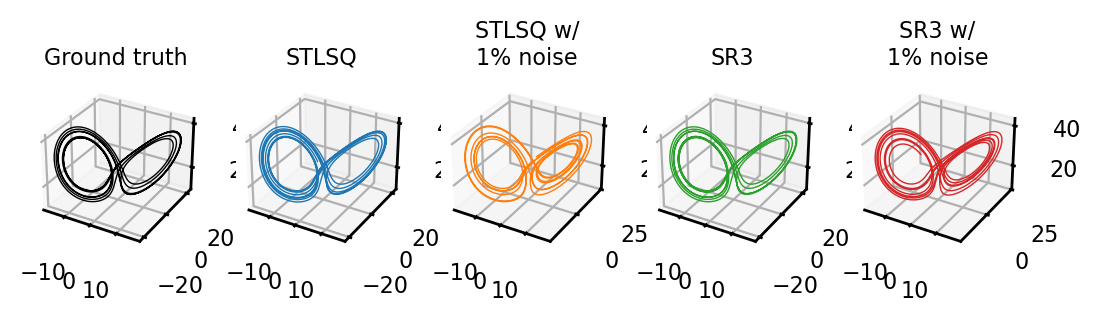

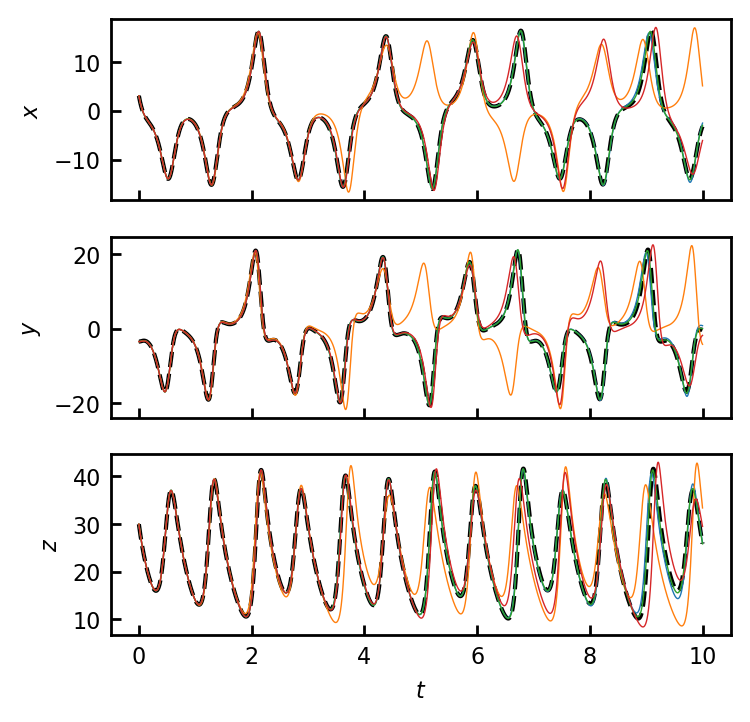

In [39]:
import pysindy as ps

# Noise to be added
percent = 1
noise_scale = 0.01 * percent * np.mean(np.linalg.norm(xyz0, axis=1))
noise = np.random.normal(scale=noise_scale, size=xyz0.shape)

# Generate test data
t0_sim, t1_sim = 0, 10
tt_sim = np.arange(t0_sim, t1_sim, dt)

xyz_sim = solve_ivp(lorenz_system, [t0_sim, t1_sim], xyz0[-1], t_eval=tt_sim).y.T

fig1, ax1 = plt.subplots(1, 5, subplot_kw={'projection': '3d'})
fig2, ax2 = plt.subplots(3, 1, figsize=(4, 4), sharex=True)

ax2[2].set_xlabel('$t$')
ax2[0].set_ylabel('$x$')
ax2[1].set_ylabel('$y$')
ax2[2].set_ylabel('$z$')

color='black'
ax1[0].plot(xyz_sim[:, 0], xyz_sim[:, 1], xyz_sim[:, 2], color=color, linewidth=0.5)
for i in range(3):
    ax2[i].plot(tt_sim, xyz_sim[:, i], color=color, linestyle='--')
ax1[0].set_title('Ground truth')


print('---------------------------')
print('STLSQ algorithm')
stlsq = ps.SINDy(
    optimizer=ps.STLSQ(threshold=1e-1),
    feature_library=ps.PolynomialLibrary(degree=3),
)
stlsq.fit(xyz0, t=dt)
stlsq.print()

xyz_sindy = stlsq.simulate(xyz0[-1], tt_sim)

color = 'tab:blue'
ax1[1].plot(xyz_sindy[:, 0], xyz_sindy[:, 1], xyz_sindy[:, 2], color=color, linewidth=0.5)
for i in range(3):
    ax2[i].plot(tt_sim, xyz_sindy[:, i], color=color, linewidth=0.5)
ax1[1].set_title('STLSQ')

print(f'\nwith {percent}% noise')
stlsq.fit(xyz0 + noise, t=dt)
stlsq.print()

xyz_sindy = stlsq.simulate(xyz0[-1], tt_sim)

color = 'tab:orange'
ax1[2].plot(xyz_sindy[:, 0], xyz_sindy[:, 1], xyz_sindy[:, 2], color=color, linewidth=0.5)
for i in range(3):
    ax2[i].plot(tt_sim, xyz_sindy[:, i], color=color, linewidth=0.5)
ax1[2].set_title(f'STLSQ w/\n{percent}% noise') 

print('---------------------------')
print('SR3 algorithm')
sr3 = ps.SINDy(
    optimizer=ps.SR3(threshold=1e-1),
    feature_library=ps.PolynomialLibrary(degree=3),
)
sr3.fit(xyz0, t=dt)
sr3.print()

xyz_sindy = sr3.simulate(xyz0[-1], tt_sim)

color = 'tab:green'
ax1[3].plot(xyz_sindy[:, 0], xyz_sindy[:, 1], xyz_sindy[:, 2], color=color, linewidth=0.5)
for i in range(3):
    ax2[i].plot(tt_sim, xyz_sindy[:, i], color=color, linewidth=0.5)
ax1[3].set_title('SR3')


print(f'\nwith {percent}% noise')
sr3.fit(xyz0 + noise, t=dt)
sr3.print()

xyz_sindy = sr3.simulate(xyz0[-1], tt_sim)

color = 'tab:red'
ax1[4].plot(xyz_sindy[:, 0], xyz_sindy[:, 1], xyz_sindy[:, 2], color=color, linewidth=0.5)
for i in range(3):
    ax2[i].plot(tt_sim, xyz_sindy[:, i], color=color, linewidth=0.5)
ax1[4].set_title(f'SR3 w/\n{percent}% noise')

---------------------------
PySINDy STLSQ algorithm
(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.805 x0 + -0.955 x1 + -0.994 x0 x2
(x2)' = -2.667 x2 + 0.999 x0 x1
(10000, 3) (10000,)

MySINDy STLSQ algorithm
(x0)' = -10.004 x0 + 10.004 x1
(x1)' = 27.805 x0 + -0.955 x1 + -0.994 x0 x2
(x2)' = -2.667 x2 + 0.999 x0 x1


Text(0.5, 0.92, 'MySINDy STLSQ')

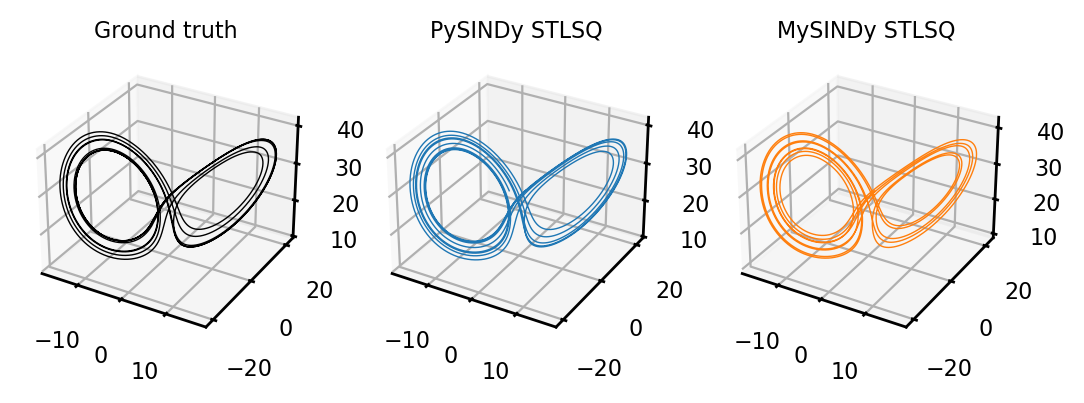

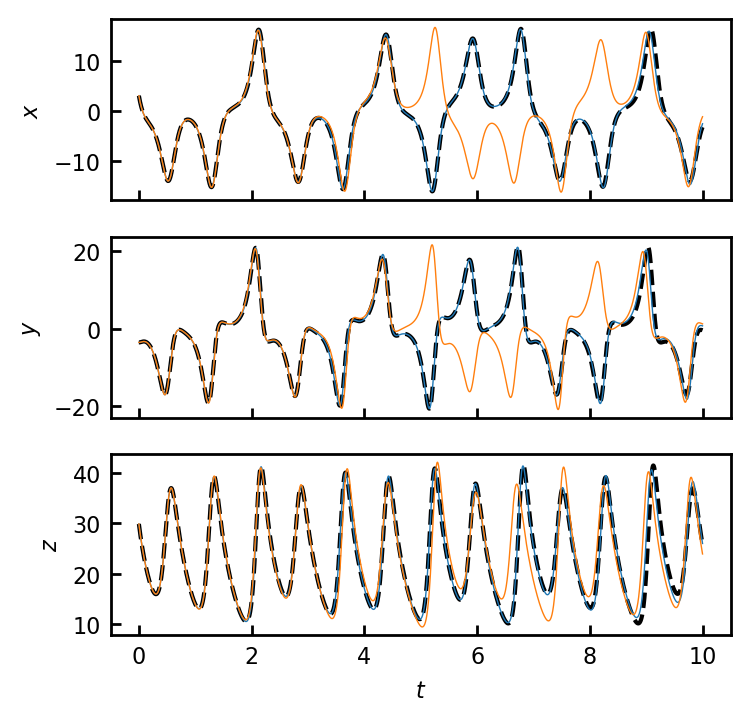

In [92]:
import pysindy as ps
from library import PolynomialLibrary
from stlsq import STLSQ
from sindy import MySINDy
from finite_difference import FiniteDifference

fig1, ax1 = plt.subplots(1, 3, subplot_kw={'projection': '3d'})
fig2, ax2 = plt.subplots(3, 1, figsize=(4, 4), sharex=True)

ax2[2].set_xlabel('$t$')
ax2[0].set_ylabel('$x$')
ax2[1].set_ylabel('$y$')
ax2[2].set_ylabel('$z$')

color='black'
ax1[0].plot(xyz_sim[:, 0], xyz_sim[:, 1], xyz_sim[:, 2], color=color, linewidth=0.5)
for i in range(3):
    ax2[i].plot(tt_sim, xyz_sim[:, i], color=color, linestyle='--')
ax1[0].set_title('Ground truth')

print('---------------------------')
print('PySINDy STLSQ algorithm')
stlsq = ps.SINDy(
    optimizer=ps.STLSQ(threshold=1e-1),
    feature_library=ps.PolynomialLibrary(degree=3),
)
stlsq.fit(xyz0, t=dt)
stlsq.print()

xyz_sindy = stlsq.simulate(xyz0[-1], tt_sim)
print(xyz_sindy.shape, tt_sim.shape)

color = 'tab:blue'
ax1[1].plot(xyz_sindy[:, 0], xyz_sindy[:, 1], xyz_sindy[:, 2], color=color, linewidth=0.5)
for i in range(3):
    ax2[i].plot(tt_sim, xyz_sindy[:, i], color=color, linewidth=0.5)
ax1[1].set_title('PySINDy STLSQ')

print(f'\nMySINDy STLSQ algorithm')
stlsq = MySINDy(
    optimizer=STLSQ(threshold=1e-1, alpha=0.1),
    library=PolynomialLibrary(degree=3),
    differentiator=FiniteDifference(),
)
stlsq.fit(xyz0, t=dt)
stlsq.print()

xyz_sindy = stlsq.simulate(xyz0[-1], tt_sim)

color = 'tab:orange'
ax1[2].plot(xyz_sindy[:, 0], xyz_sindy[:, 1], xyz_sindy[:, 2], color=color, linewidth=0.5)
for i in range(3):
    ax2[i].plot(tt_sim, xyz_sindy[:, i], color=color, linewidth=0.5)
ax1[2].set_title(f'MySINDy STLSQ') 